# Result analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from kmodes.kmodes import KModes

import IPython

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display

import plotly.graph_objects as go

#%matplotlib ipympl

## Setup

In [2]:
def echo(df):
    print(df)
    return df
EchoTransformer = FunctionTransformer(echo)

def custom_date_transform(df):
    out = pd.DataFrame()
    for col in df.columns:
        out[col] = df[col].dt.year + ((df[col].dt.month-1)/12)
    return out
CustomDateTransformer = FunctionTransformer(custom_date_transform)

def zero_to_na_transform(df):
    return df[['price', 'reviews']].replace(0, np.nan)
ZeroToNaTransformer = FunctionTransformer(zero_to_na_transform)

def wrap_model(scaler=StandardScaler, encoder=lambda:OneHotEncoder(sparse_output=False), imputer=lambda:SimpleImputer(strategy="median"), transformers=[], poly=False):
    def inner(model):
        return make_pipeline(
            *transformers,
            make_column_transformer(
                (
                    make_pipeline(
                        *([imputer() if imputer else []]),
                        scaler(),
                    ), make_column_selector(dtype_include=[np.number, bool])
                ),
                (
                    make_pipeline(
                        CustomDateTransformer,
                        *([imputer() if imputer else []]),
                        scaler(),
                    ), make_column_selector(dtype_include='datetime')
                ),
                (encoder(), make_column_selector(dtype_include=object)),
            ), 
            *([PolynomialFeatures(2, interaction_only=True)] if poly else []), 
            model
        )
    return inner

def pt_pipeline():
    return make_pipeline(
        StandardScaler(),
        PowerTransformer()
    )

def scatter3D(df,x,y,z,hue):
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')
    for h in np.unique(hue):
        gdf = df[hue==h]
        ax1.scatter(gdf[x],gdf[y],gdf[z],label=h)
        ax1.set_xlabel(x)
        ax1.set_ylabel(y)
        ax1.set_zlabel(z)
    """
    ax2 = fig.add_subplot(122)
    for h in np.unique(hue):
        gdf = df[hue==h]
        plt.scatter(gdf[x],gdf[y],label=h)
    """
    return ax1

def cluster_visualize(X, cluster=KMeans(n_clusters=5, n_init='auto'), pca_dims=2, preprocess=wrap_model()):
    km = preprocess(cluster).fit(X)
    groups = km[-1].labels_
    
    pca = preprocess(PCA(n_components=pca_dims)).fit(X)
    pca_out = pd.DataFrame(pca.transform(X))
    if pca_dims == 3:
        return scatter3D(pca_out, x=0, y=1, z=2, hue=groups)
    else:
        return sns.scatterplot(pca_out, x=0, y=1, hue=groups, palette='deep')

def cluster_on_pca(X, cluster=KMeans(n_clusters=5, n_init='auto'), pca_dims=2, preprocess=wrap_model()):
    pca = preprocess(PCA(n_components=pca_dims)).fit(X)
    pca_out = pd.DataFrame(pca.transform(X))

    km = preprocess(cluster).fit(pca_out)
    groups = km[-1].labels_
    return groups

def cluster_visualize_on_pca(X, cluster=KMeans(n_clusters=5, n_init='auto'), pca_dims=2, preprocess=wrap_model()):
    pca = preprocess(PCA(n_components=pca_dims)).fit(X)
    pca_out = pd.DataFrame(pca.transform(X))

    km = preprocess(cluster).fit(pca_out)
    groups = km[-1].labels_
    
    if pca_dims == 3:
        return scatter3D(pca_out, x=0, y=1, z=2, hue=groups)
    else:
        return sns.scatterplot(pca_out, x=0, y=1, hue=groups, palette='deep')

def elbow(K, cost):
    plt.figure()
    plt.plot(K, cost, 'bx-')
    plt.xlabel('No. of clusters')
    plt.ylabel('Cost')
    plt.xticks(K)
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [3]:
dataset = pd.read_csv('kindle_data-v2.csv')

df = dataset.drop(['asin', 'imgUrl', 'productURL', 'category_id'], axis=1)
df.publishedDate = pd.to_datetime(dataset.publishedDate)

X = df.drop(['title', 'author', 'soldBy'], axis=1).copy()
X['soldByAmazon'] = df.soldBy.str.contains('Amazon').astype(bool)
X

# Clipped and marked (marks disabled)
X2 = X.copy()
X2['reviewsClipped'] = X2.reviews > 365 
X2['priceClipped'] = X2.price > 15 
X2['dateClipped'] = X2.publishedDate.dt.year < 2000

X2.reviews.clip(upper=365, inplace=True)
X2.price.clip(upper=15, inplace=True)
X2.publishedDate.clip(lower=pd.Timestamp('2000-01-01'), inplace=True)

#X2.reviews.replace(0, np.nan, inplace=True)
#X2.price.replace(0, np.nan, inplace=True)

X2.price = np.log1p(X2.price)
X2.reviews = np.log1p(X2.reviews)

# unbalanced boolean features removed
X3 = X2.select_dtypes(exclude=['bool']).copy()

# Metacategories
Lifestyle = [ 'Parenting & Relationships', 'Sports & Outdoors', 'Health, Fitness & Dieting', 'Self-Help', 'Cookbooks, Food & Wine', 'Crafts, Hobbies & Home' ]
Stories = [ "Children's eBooks", 'Mystery, Thriller & Suspense', 'Literature & Fiction',  'Biographies & Memoirs', 'Teen & Young Adult', 'Travel', 'LGBTQ+ eBooks', 'Religion & Spirituality', 'Comics', 'Arts & Photo graphy', 'Science Fiction & Fantasy', 'Nonfiction', 'Romance', 'Humor & Entertainment']
Educational = ['Engineering & Transportation', 'Science & Math','Computers & Technology', 'Politics & Social Sciences', 'Foreign Language', 'Education & Teaching', 'History', 'Reference', 'Medical', 'Business & Money', 'Law' ]

map = {}
map.update({val: 'Lifestyle' for val in Lifestyle})
map.update({val: 'Stories' for val in Stories})
map.update({val: 'Educational' for val in Educational})

X4 = X3.copy().drop('category_name', axis=1)
X4['category'] = X3.category_name.map(map)
X4.category.isna().sum()

# Author works (how many total books written by this author)
X5 = X4.copy()
X5['authorWorks'] = np.log(df.author.map(df.author.value_counts().to_dict()).fillna(1).astype(int))
X5.authorWorks.clip(upper=2.89, inplace=True)

## Minmax Birch (Abandoned)

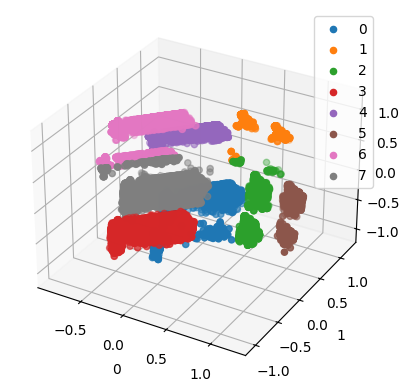

In [19]:
from sklearn.cluster import Birch

cl = Birch(n_clusters=8, threshold=0.1)
cluster_visualize_on_pca(X2, cluster=cl, pca_dims=3,
                  preprocess=wrap_model(MinMaxScaler))
plt.legend()
plt.show()

In [20]:
labels = pd.DataFrame()
labels['label'] = cl.labels_
df.groupby(labels.label).describe().T

label                                            0  \
stars         count                        18602.0   
              mean                        4.455032   
              min                              0.0   
              25%                              4.4   
              50%                              4.5   
              75%                              4.6   
              max                              5.0   
              std                         0.445004   
reviews       count                        18602.0   
              mean                       48.010537   
              min                              0.0   
              25%                              0.0   
              50%                              0.0   
              75%                             44.0   
              max                            365.0   
              std                         92.97285   
price         count                        18602.0   
              mean                       11.073737   
              min                              0.0   
              25%                             9.99   
              50%                            11.99   
              75%                            13.99   
              max                             15.0   
              std                         3.382544   
publishedDate count                          14077   
              mean   2016-07-19 12:39:07.659302144   
              min              1967-09-09 00:00:00   
              25%              2012-01-31 00:00:00   
              50%              2017-10-17 00:00:00   
              75%              2021-11-16 00:00:00   
              max              2023-10-01 00:00:00   
              std                              NaN   

label                                         1  \
stars         count                      1953.0   
              mean                     4.628418   
              min                           3.7   
              25%                           4.5   
              50%                           4.7   
              75%                           4.7   
              max                           4.9   
              std                      0.167205   
reviews       count                      1953.0   
              mean                  2027.351254   
              min                         366.0   
              25%                         510.0   
              50%                         797.0   
              75%                        1628.0   
              max                      126810.0   
              std                   5756.175216   
price         count                      1953.0   
              mean                     24.72214   
              min                          15.1   
              25%                         16.99   
              50%                         19.25   
              75%                          27.0   
              max                         218.0   
              std                     13.926822   
publishedDate count                        1403   
              mean   2016-01-13 01:40:35.067712   
              min           1965-11-30 00:00:00   
              25%           2013-04-16 00:00:00   
              50%           2017-02-21 00:00:00   
              75%           2020-03-31 12:00:00   
              max           2023-09-12 00:00:00   
              std                           NaN   

label                                            2  \
stars         count                        19326.0   
              mean                        4.522384   
              min                              3.1   
              25%                              4.4   
              50%                              4.5   
              75%                              4.7   
              max                              5.0   
              std                         0.195903   
reviews       count                        1932

In [21]:
df.groupby(labels.label).size()

label
0    18602
1     1953
2    19326
3    22995
4     7219
5    11986
6    19053
7    31968
dtype: int64

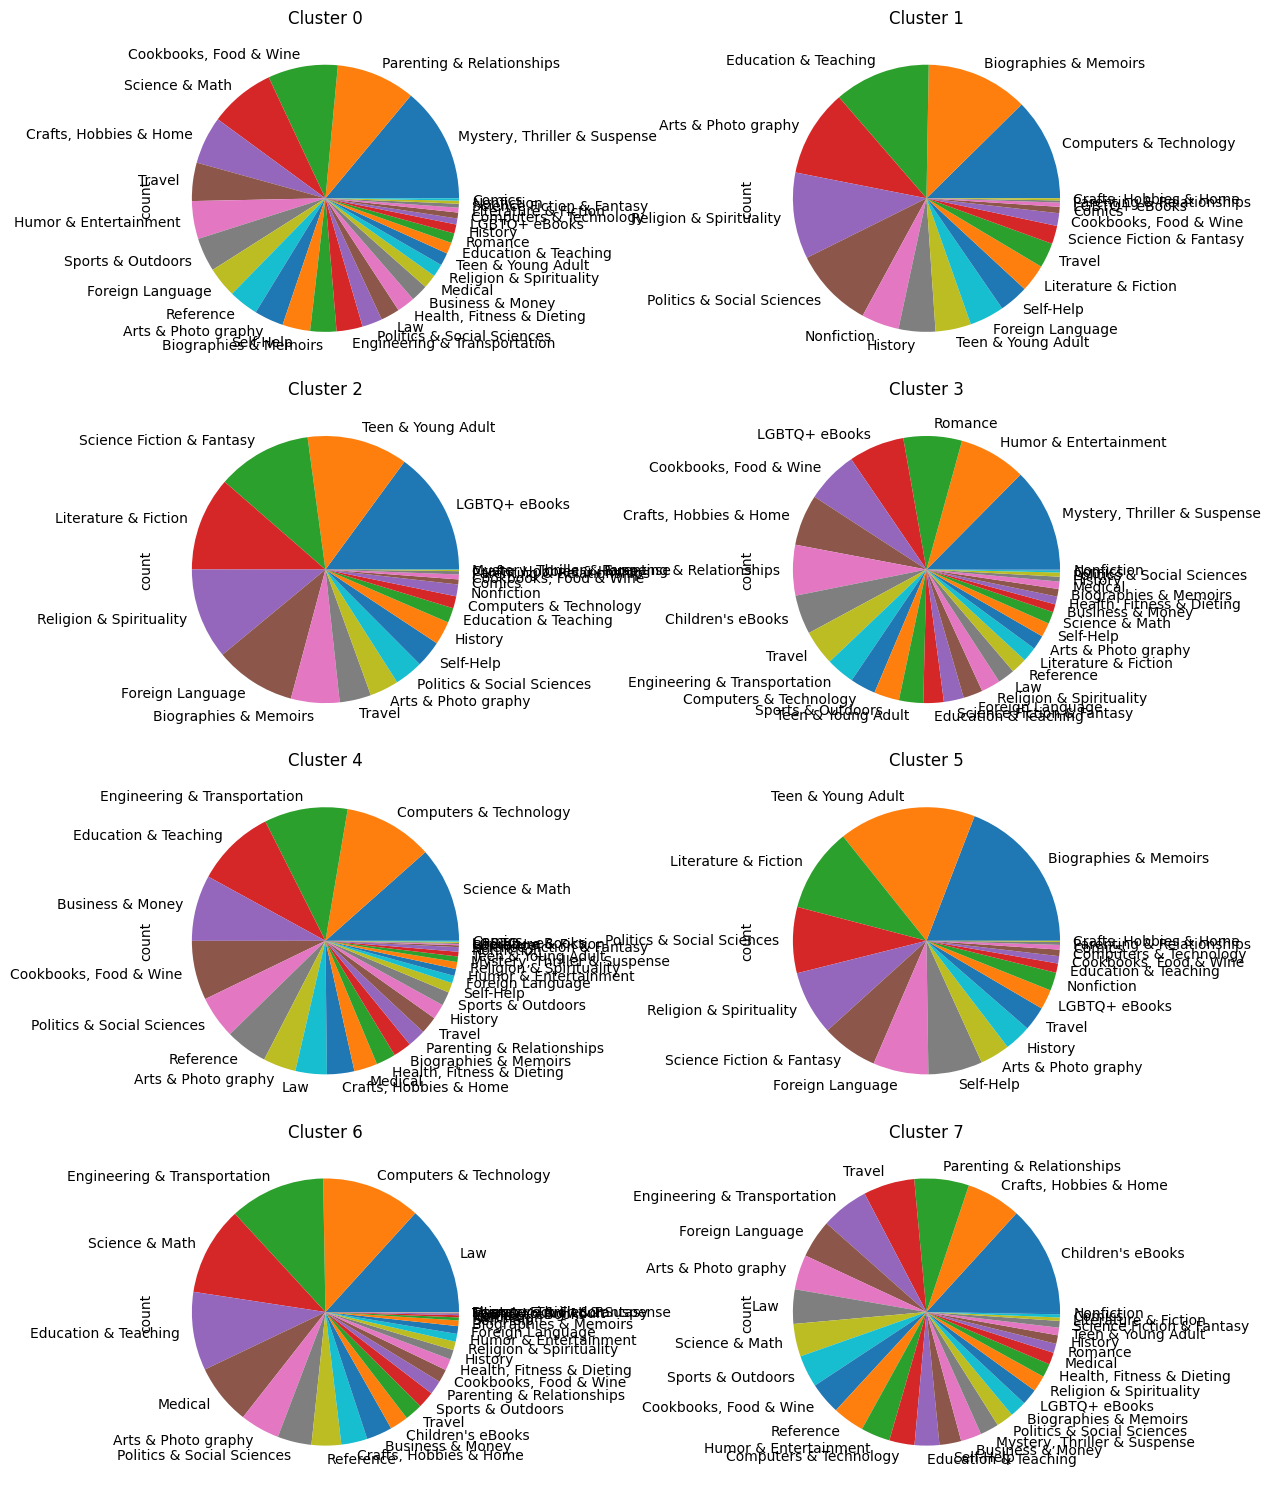

In [22]:
plt.figure(figsize=(12,15))
for i, (group, gdf) in enumerate(df.groupby(labels.label)):
    plt.subplot(4,2,i+1)
    gdf['category_name'].value_counts().plot.pie(title='Cluster ' + str(group))
plt.tight_layout()
plt.show()

In [23]:
tags = pd.DataFrame()
tags['award'] = df.isBestSeller.map({True: 'isBestSeller', False: ''}) + df.isEditorsPick.map({True: 'isEditorsPick', False: ''}) + df.isGoodReadsChoice.map({True: 'isGoodReadsChoice', False: ''})
tags['award'] = tags.award.map(lambda x: x if x != '' else 'None')

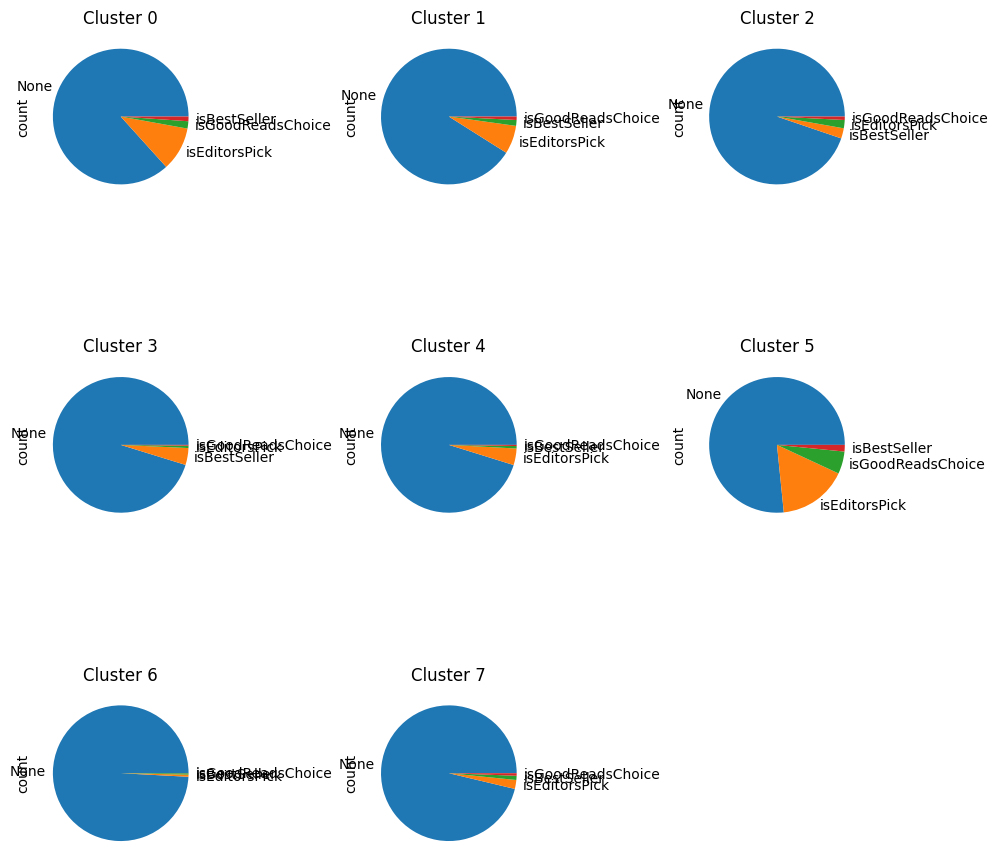

In [24]:
plt.figure(figsize=(10,10))
for i, (group, gdf) in enumerate(df.groupby(labels.label)):
    plt.subplot(3,3,i+1)
    tags.iloc[gdf.index]['award'].value_counts().plot.pie(title='Cluster ' + str(group))
plt.tight_layout()
plt.show()

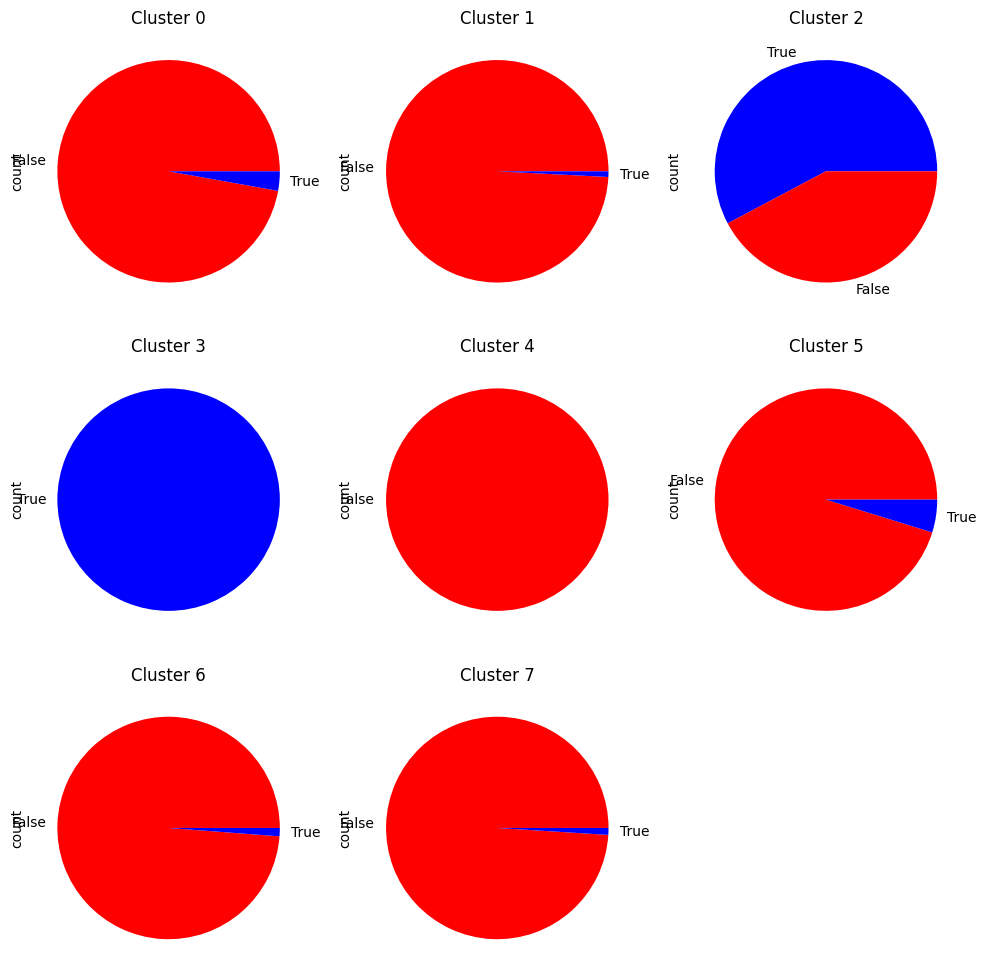

In [25]:
colors = { True: 'blue', False: 'red' }
plt.figure(figsize=(10,10))
for i, (group, gdf) in enumerate(df.groupby(labels.label)):
    plt.subplot(3,3,i+1)
    counts = gdf.isKindleUnlimited.value_counts()
    counts.plot.pie(title='Cluster ' + str(group), colors=[colors[v] for v in counts.keys()])
plt.tight_layout()
plt.show()

## KMeans StandardScaler

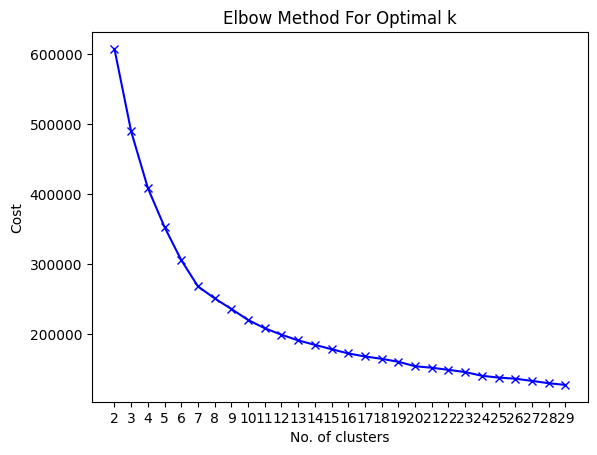

In [26]:
cost = []
K = range(2,30,1)
for num_clusters in K:
    km = KMeans(n_clusters=num_clusters, n_init='auto', init='random')
    wrap_model(StandardScaler)(km).fit(X5)
    cost.append(km.inertia_)

elbow(K, cost)

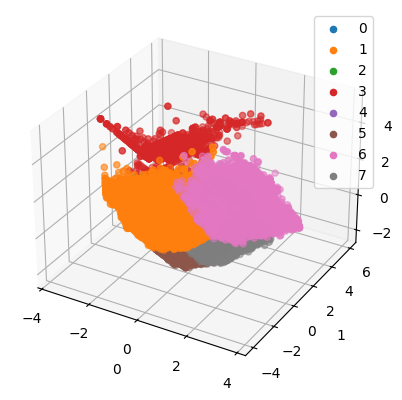

In [27]:
cl = KMeans(n_clusters=8, n_init='auto')
cluster_visualize(X5, cluster=cl, pca_dims=3,
                  preprocess=wrap_model(StandardScaler))
plt.legend()
plt.show()

In [28]:
labels = pd.DataFrame()
labels['label'] = cl.labels_
df.groupby(labels.label).describe().T

label                                            0  \
stars         count                        15807.0   
              mean                        4.518315   
              min                              2.0   
              25%                              4.4   
              50%                              4.5   
              75%                              4.7   
              max                              5.0   
              std                         0.240409   
reviews       count                        15807.0   
              mean                        0.347757   
              min                              0.0   
              25%                              0.0   
              50%                              0.0   
              75%                              0.0   
              max                             19.0   
              std                          1.89446   
price         count                        15807.0   
              mean                        8.907669   
              min                             1.49   
              25%                             4.99   
              50%                             6.89   
              75%                             9.99   
              max                            262.2   
              std                        10.480381   
publishedDate count                           6284   
              mean   2019-06-22 01:43:07.141947904   
              min              2009-01-13 00:00:00   
              25%              2017-01-20 18:00:00   
              50%              2020-04-02 00:00:00   
              75%              2022-06-07 00:00:00   
              max              2024-01-16 00:00:00   
              std                              NaN   

label                                            1  \
stars         count                        14255.0   
              mean                        4.495475   
              min                              1.8   
              25%                              4.4   
              50%                              4.5   
              75%                              4.6   
              max                              5.0   
              std                          0.22645   
reviews       count                        14255.0   
              mean                      633.686426   
              min                              0.0   
              25%                              0.0   
              50%                              0.0   
              75%                            340.0   
              max                          92806.0   
              std                      2883.709866   
price         count                        14255.0   
              mean                       16.635235   
              min                              0.0   
              25%                             9.99   
              50%                            12.99   
              75%                            14.99   
              max                            423.0   
              std                        17.121446   
publishedDate count                          14255   
              mean   2008-06-07 10:36:12.374605312   
              min              1806-01-01 00:00:00   
              25%              2007-07-10 00:00:00   
              50%              2010-03-16 00:00:00   
              75%              2011-12-14 00:00:00   
              max              2015-03-17 00:00:00   
              std                              NaN   

label                                            2  \
stars         count                        21115.0   
              mean                         4.52081   
              min                              2.2   
              25%                              4.4   
              50%                              4.6   
              75%                              4.7   
              max                              5.0   
  

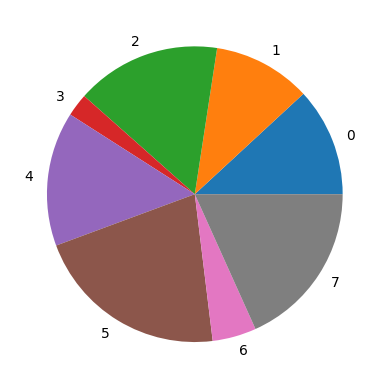

In [29]:
plt.figure()
(df.groupby(labels.label).size() / len(df) * 100).plot.pie()
plt.show()

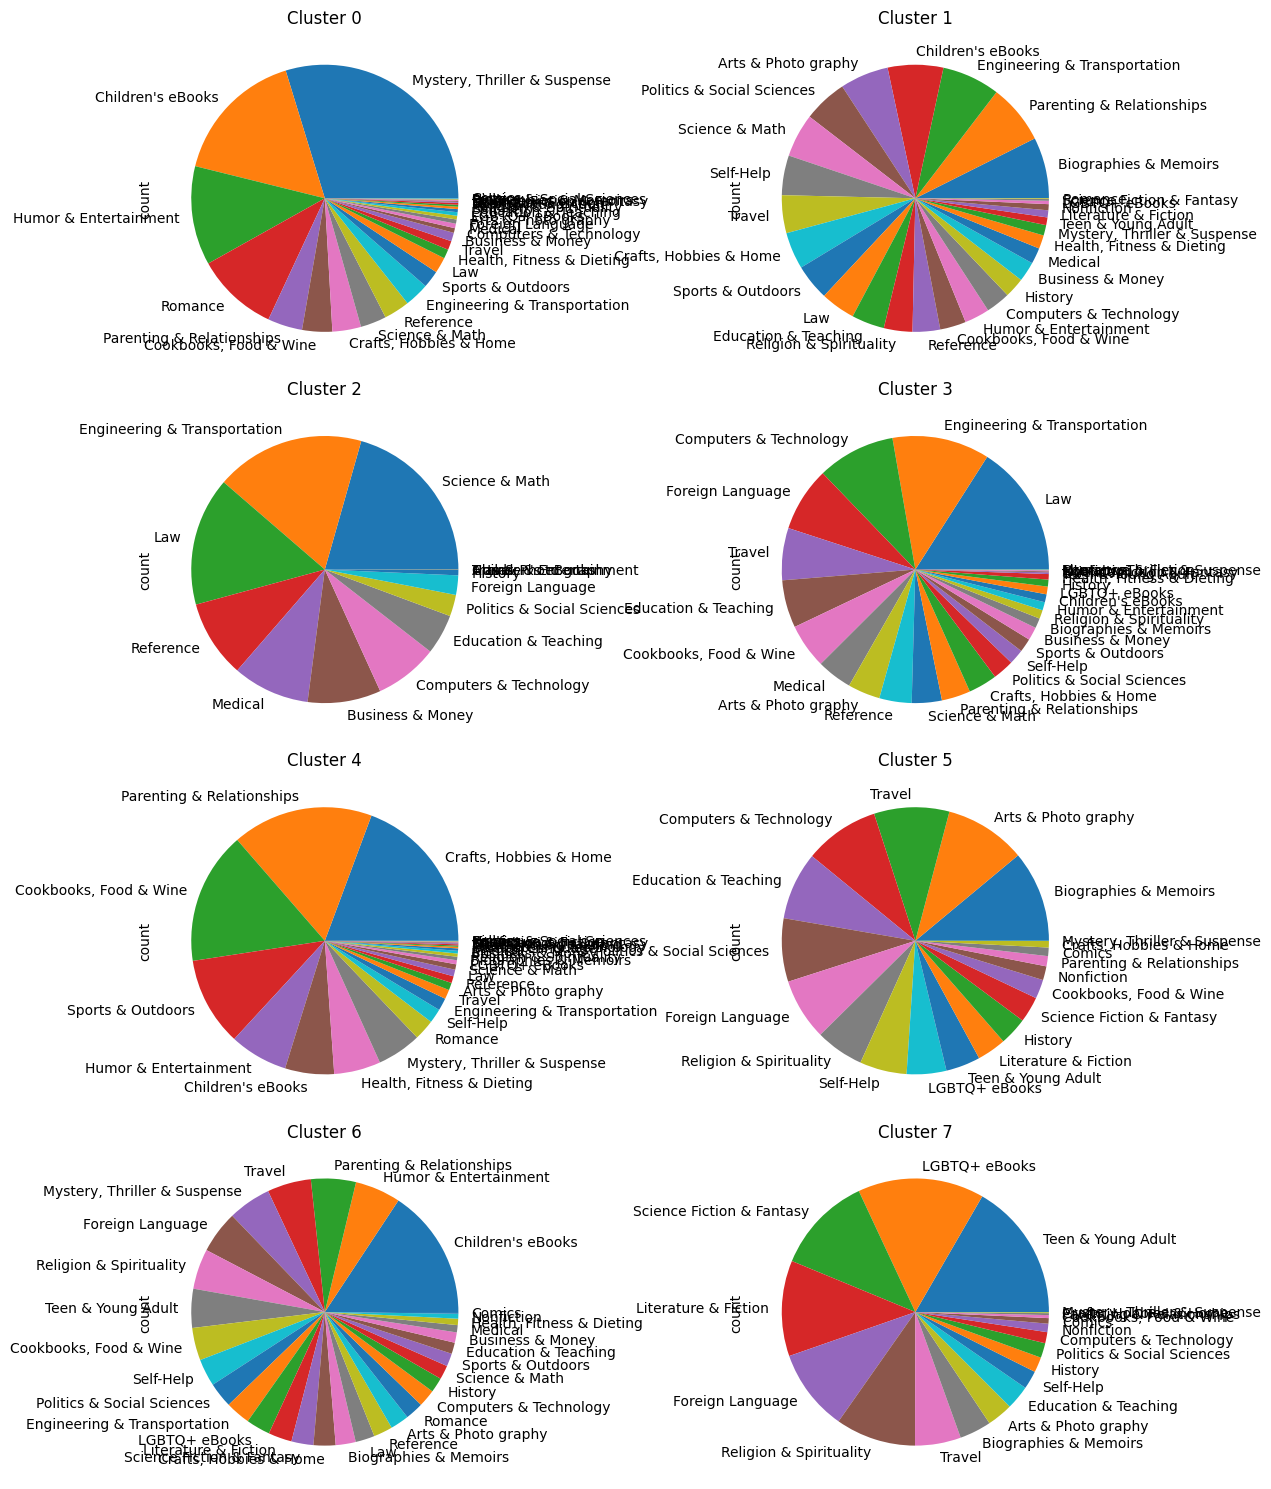

In [30]:
plt.figure(figsize=(12,15))
for i, (group, gdf) in enumerate(df.groupby(labels.label)):
    plt.subplot(4,2,i+1)
    gdf['category_name'].value_counts().plot.pie(title='Cluster ' + str(group))
plt.tight_layout()
plt.show()

In [35]:
tags = pd.DataFrame()
tags['award'] = df.isBestSeller.map({True: 'isBestSeller', False: ''}) + df.isEditorsPick.map({True: 'isEditorsPick', False: ''}) + df.isGoodReadsChoice.map({True: 'isGoodReadsChoice', False: ''})
tags['award'] = tags.award.map(lambda x: x if x != '' else 'None')

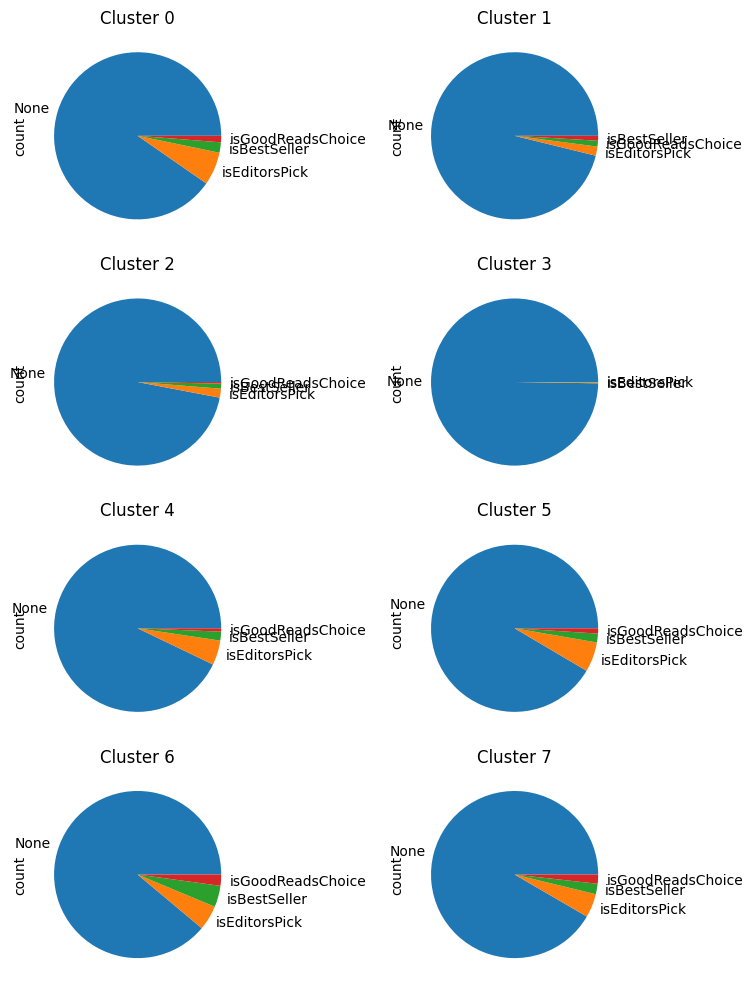

In [36]:
plt.figure(figsize=(8,10))
for i, (group, gdf) in enumerate(df.groupby(labels.label)):
    plt.subplot(4,2,i+1)
    tags.iloc[gdf.index]['award'].value_counts().plot.pie(title='Cluster ' + str(group))
plt.tight_layout()
plt.show()

Kindle Unlimited Distributions


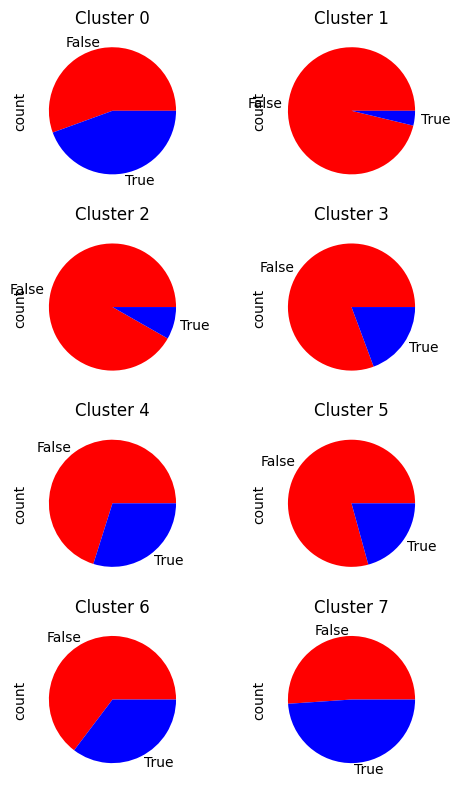

In [42]:
colors = { True: 'blue', False: 'red' }
print('Kindle Unlimited Distributions')
plt.figure(figsize=(5,8))
for i, (group, gdf) in enumerate(df.groupby(labels.label)):
    plt.subplot(4,2,i+1)
    counts = gdf.isKindleUnlimited.value_counts()
    counts.plot.pie(title='Cluster ' + str(group), colors=[colors[v] for v in counts.keys()])
plt.tight_layout()
plt.show()

Sold by amazon distribution


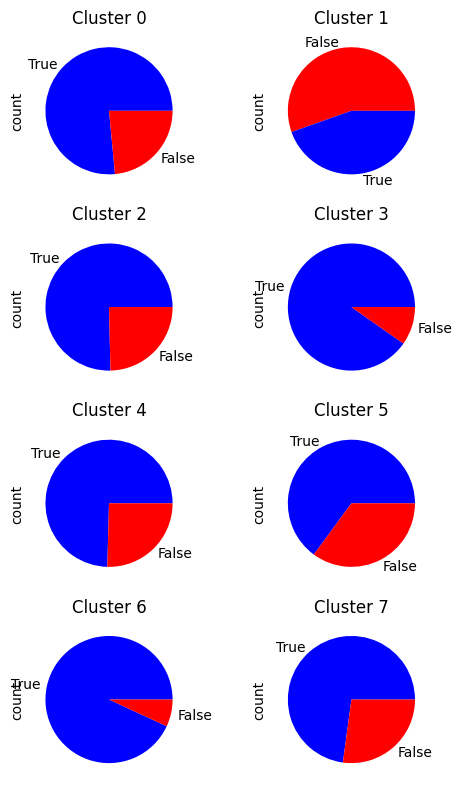

In [44]:
colors = { True: 'blue', False: 'red' }
print('Sold by amazon distribution')
plt.figure(figsize=(5,8))
for i, (group, gdf) in enumerate(X.groupby(labels.label)):
    plt.subplot(4,2,i+1)
    counts = gdf.soldByAmazon.value_counts()
    counts.plot.pie(title='Cluster ' + str(group), colors=[colors[v] for v in counts.keys()])
plt.tight_layout()
plt.show()

In [48]:
(np.e**X5.authorWorks).groupby(labels.label).describe().T


label,0,1,2,3,4,5,6,7
count,15807.000000,14255.000000,21115.000000,3326.000000,19563.000000,28335.000000,6388.000000,24313.000000
mean,11.344778,3.387080,1.616244,2.231332,1.584777,1.620152,6.033040,11.310848
std,5.525594,4.143395,1.121902,3.297626,0.935398,0.918210,5.972846,5.479970
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000
50%,11.000000,2.000000,1.000000,1.000000,1.000000,1.000000,3.000000,11.000000
75%,17.993310,4.000000,2.000000,2.000000,2.000000,2.000000,9.000000,17.993310
max,17.993310,17.993310,8.000000,17.993310,6.000000,6.000000,17.993310,17.993310


Klaster 0 = Fiction za odrasle:
* Nema reviews
* Starija publika
* Najvise serijskih autora

Klaster 1 = Starije knjige:
* Starije knjige
* Skuplje nego obično

Klaster 2 i 3 = Knjige ze edukaciju:
* Nemaju toliko reviews
* Najskuplji klasteri
* Klaster 3 specifično su outliers knjiga koje nemaju ocene.
* Gotovo svi autori su napisali samo 1 rad.

Klaster 4 = Lifestyle knjige bez reviews:
* Gotovo svi autori su napisali samo 1 rad.

Klaster 5 = Lifestyle knjige sa reviews:
* jedna od dve katergorije sa najvise reviews
* Gotovo svi autori su napisali samo 1 rad.

Klaster 6 = Outlier knjige bez ocena

Klaster 7 = Fiction knjige za mladje
* jedna od dve katergorije sa najvise reviews
* Najvise serijskih autora